### Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

---
# Callibration & Undistortion
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [2]:
#Helper functions
def drawChessBoardCorners(images):
    objpoints = [] 
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img_chessboard = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            file_name = fname[:len(fname) - 4] + '_corners'
            mpimg.imsave(file_name + '.jpg', img_chessboard)       
    return(img, objpoints, imgpoints)

def undistortImage(image, objpoints, imgpoints, image_shape):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return(undistorted, mtx, dist)

Chessboard Images loaded
Calibrated & Undistorted


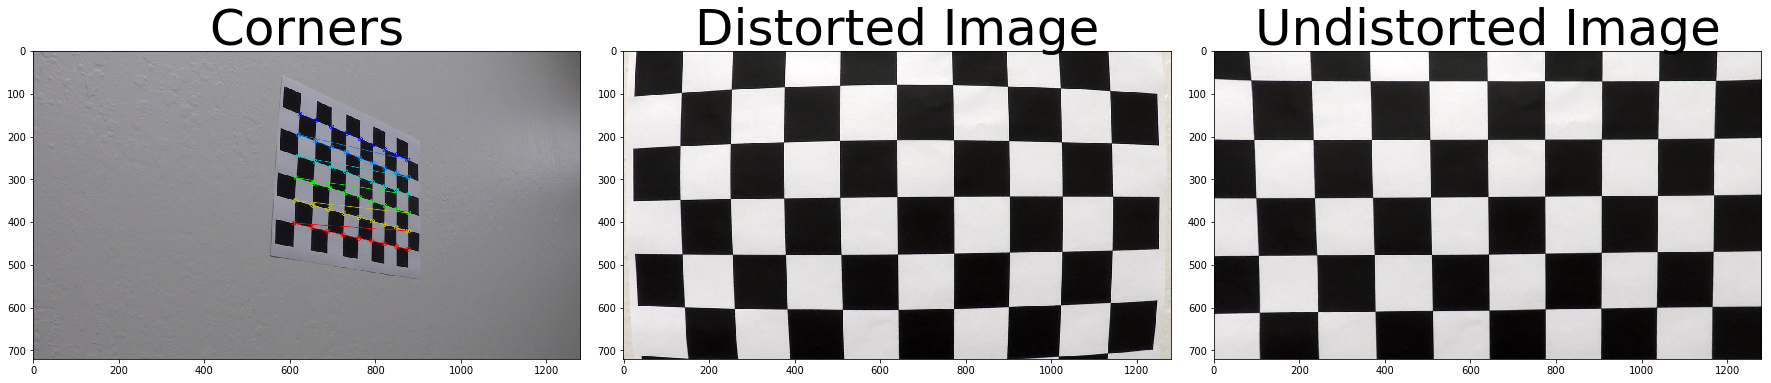

In [6]:
images = glob.glob('camera_cal/calibration*.jpg')
print('Chessboard Images loaded')

test_image = mpimg.imread(images[0])
chessboardImage, objpoints, imgpoints = drawChessBoardCorners(images)
undistorted, mtx, dist = undistortImage(test_image, objpoints, imgpoints, test_image.shape[1::-1])
mpimg.imsave(output_path + 'chessboard_with_corners_drawn.jpg', chessboardImage)  
mpimg.imsave(output_path + 'chessboard_undistorted.jpg', undistorted)  

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboardImage)
ax1.set_title('Corners', fontsize=50)
ax2.imshow(test_image)
ax2.set_title('Distorted Image', fontsize=50)
ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Calibrated & Undistorted")

---
## 2. Color & Gradient Thresholds

The following are the functions to calculate Gradient and Color Thresholds.

As a color thresholding technique, I used the combination of HSV and HLS by extracting the 'V' and 'S' channel respectively and applying the appropirate thresholds.

In [23]:
#Helper Functions
def convertRGBToHLS(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)

def convertRGBToHSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2. Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3. Take the absolute value of the derivative or gradient
    abssobelx = np.absolute(sobel)
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abssobelx/np.max(abssobelx))
    # 5. Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbxbinary = np.zeros_like(scaled_sobel)
    sbxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx**2)
    abs_sobely = np.sqrt(sobely**2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctanxy = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(arctanxy >= thresh[0]) & (arctanxy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    #Applying threshold  by combining 'S' channel of HLS and 'V' channel of HSV
    
    #1. Convert to HLS.
    hls_image = convertRGBToHLS(image)
    
    #2. Extract 'S' channel.
    s_channel = hls_image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    #3. Thresholding
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    #4. Conver to HSV
    hsv_image = convertRGBToHSV(image)
    #5. Extract the 'V' Component.
    v_channel = hsv_image[:,:,2]
    v_binary = np.zeros_like(v_channel)
    #6. Thresholding
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_binary)
    #7. Combining the results.
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

def getHistogramValues(image):
    return np.sum(image[image.shape[0]//2:,:], axis=0)

#Calculates Perspective Matrix using the given the points.
def getPerspectiveMatrix(source_points, destination_points):
    return cv2.getPerspectiveTransform(source_points,destination_points)

#Warps the image using the Matrix given
def warper(image, M, image_size):    
    return cv2.warpPerspective(image, M, (image_size[0], image_size[1]) , flags=cv2.INTER_LINEAR)
    

---
### Sliding Window Search

In [8]:
def slidingWindowSearch(binary_warped, histogram, out_img):    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return(left_fit, right_fit, left_lane_inds, right_lane_inds)


## Test Images 

In [9]:
test_images_path = "./test_images/"
test_images = os.listdir(test_images_path)
output_path = "./output_images/"

## Lane Finding Pipeline for Test Images

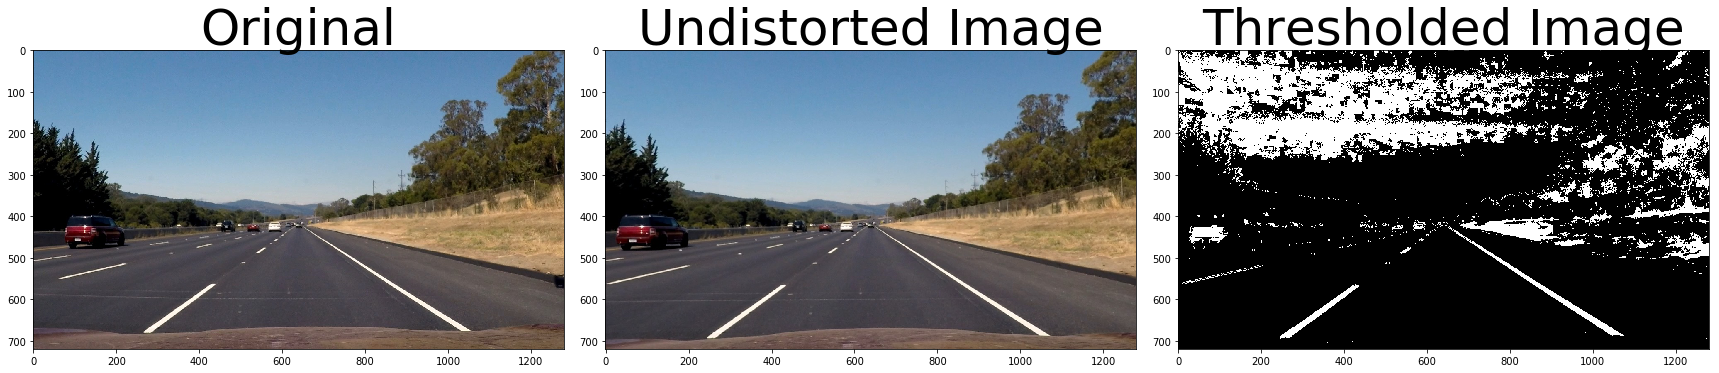

In [25]:
#Reading a test Image
image = test_images[1]    
img = mpimg.imread(test_images_path + image)

#Calculating the distortion matrix.
undistorted, mtx, dist = undistortImage(img, objpoints, imgpoints, img.shape[1::-1])   
mpimg.imsave(output_path + 'undistorted.jpg', undistorted)       

#Applying Sobel operator to find Gradient on horizontal pixels.
gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(30, 255))

#Applying Sobel operator to find Gradient on Vertical pixels
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(25, 255))

#Applying Color Threshold.
color_binary = color_threshold(undistorted, sthresh=(100,255), vthresh=(50,255))

#Create a binary image by combining the thresholds.
preProcessImage = np.zeros_like(undistorted[:,:,0])
preProcessImage[((gradx == 1) & (grady == 1)) | (color_binary == 1) ] = 255
thresholded_image = np.dstack((preProcessImage,preProcessImage,preProcessImage))
mpimg.imsave(output_path + 'thresholded.jpg', thresholded_image)


image_height = preProcessImage.shape[0]
image_width  = preProcessImage.shape[1]

source_points = np.float32([[570.,470.],[722.,470.],[1100.,image_height],[220,image_height]])
offset = 320
destination_points = np.float32([[offset,0],[image_width-offset,0],[image_width-offset,image_height],[offset,image_height]])

#Apply perspective Transform to see the view from Bird's eye.
M = getPerspectiveMatrix(source_points,destination_points)
Minv = getPerspectiveMatrix(destination_points,source_points)
warped = warper(undistorted, M, (image_width, image_height))
mpimg.imsave(output_path + 'warped.jpg', warped)

binary_warped = warper(preProcessImage, M, (image_width, image_height))
out_img = np.dstack((binary_warped,binary_warped,binary_warped))
mpimg.imsave(output_path + 'binary_warped.jpg', out_img)

#Finding Lane Lane Lines.
histogram = getHistogramValues(binary_warped)
left_fit, right_fit, left_lane_inds, right_lane_inds = slidingWindowSearch(binary_warped, histogram, out_img)
    
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(thresholded_image, cmap="gray")
ax3.set_title('Thresholded Image', fontsize=50)


### Perspective Transform Visualisation

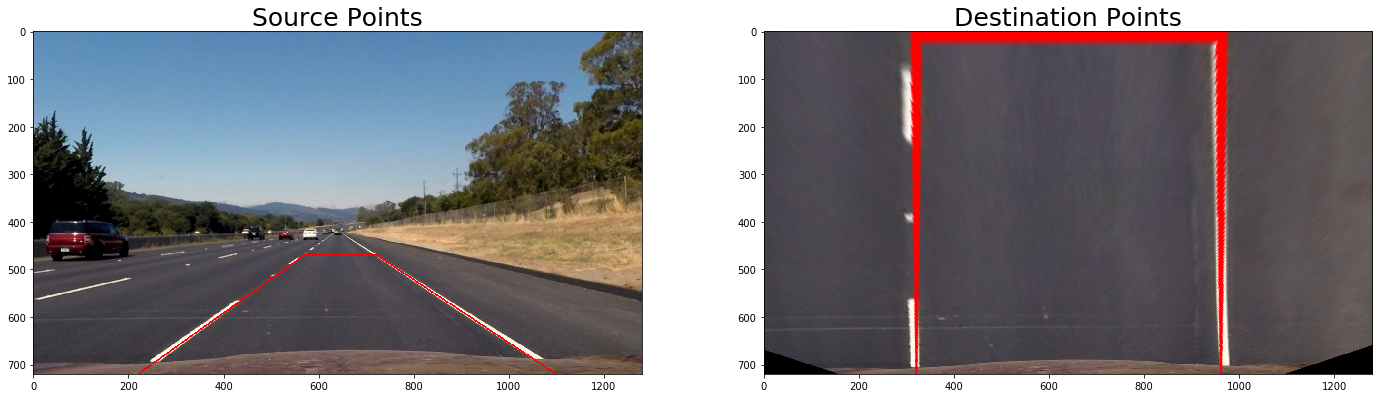

In [11]:
points = np.array([[570.,470.],[722.,470.],[1100.,image_height],[220,image_height]], np.int32)
points = points.reshape((-1,1,2))
test_polygon = np.copy(undistorted)
cv2.polylines(test_polygon,[points],True,(255,0,0), thickness=2)
mpimg.imsave(output_path + 'source.jpg', test_polygon)

source_warped = cv2.warpPerspective(test_polygon, M, (image_width, image_height) , flags=cv2.INTER_LINEAR)
mpimg.imsave(output_path + 'destination.jpg', source_warped)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(24, 9))
ax1.imshow(test_polygon)
ax1.set_title('Source Points', fontsize=25)
ax2.imshow(source_warped)
ax2.set_title('Destination Points', fontsize=25)

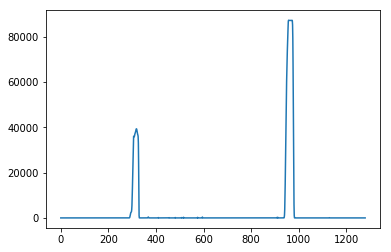

In [22]:
plt.plot(histogram)

### Sliding Window Visualisation

(720, 0)

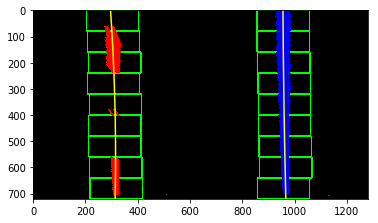

In [12]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
mpimg.imsave(output_path + 'sliding_window.jpg', out_img)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Lane Visualisation

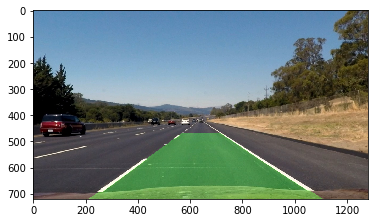

In [13]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height)) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

mpimg.imsave(output_path + 'result.jpg', result)
plt.imshow(result)

### Radius of Curvature

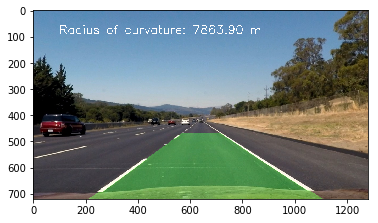

In [14]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curvature = (left_curverad + right_curverad) / 2
curvature_string = "Radius of curvature: %.2f m" % curvature
cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
plt.imshow(result)
mpimg.imsave(output_path + 'result_with_radius_of_curvature.jpg', result)

## Lanes

(720, 0)

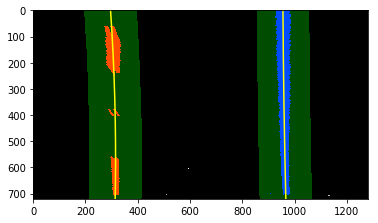

In [15]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
mpimg.imsave(output_path + 'lanes.jpg', result)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


---

## Building Video Pipeline

**Combining all together to apply on the video stream**

In [16]:
#Global Variables 
left_fit = None
right_fit = None

def findCurveFit(binary_warped, histogram):
    global left_fit, right_fit 
    if(left_fit is not None and right_fit is not None):
        left_fit, right_fit = findCurveFitAdvanced(binary_warped, left_fit, right_fit)
        return left_fit, right_fit
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin     
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return(left_fit, right_fit)

def findCurveFitAdvanced(binary_warped, left_fit, right_fit): 
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_fit, right_fit)

def findCurvature(ploty,leftx,rightx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return((left_curverad + right_curverad) / 2)
    # Example values: 632.1 m    626.2 m

def findOffset(left_fitx, right_fitx, image_size):
    lane_center = (left_fitx[image_size[1]-1] + right_fitx[image_size[1]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(image_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    return center_offset_mtrs

def drawLane(binary_warped, left_fitx, right_fitx, ploty, Minv, image_size, undistorted):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_size[0], image_size[1])) 
    # Combine the result with the original image
    return cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Video Pipeline

In [18]:
def process_image(img):
   
    undistorted, mtx, dist = undistortImage(img, objpoints, imgpoints, img.shape[1::-1])   
   
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(30, 255))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(25, 255))   
    color_binary = color_threshold(undistorted, sthresh=(100,255), vthresh=(50,255))
                            
    preProcessImage = np.zeros_like(undistorted[:,:,0])
    preProcessImage[((gradx == 1) & (grady == 1)) | (color_binary == 1) ] = 255    
    
    image_height = preProcessImage.shape[0]
    image_width  = preProcessImage.shape[1]

    source_points = np.float32([[570.,470.],[722.,470.],[1100.,image_height],[220,image_height]])
    offset = 320
    destination_points = np.float32([[offset,0],[image_width-offset,0],[image_width-offset,image_height],[offset,image_height]])
    
    M = cv2.getPerspectiveTransform(source_points,destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points,source_points)
    warped = cv2.warpPerspective(undistorted, M, (image_width, image_height) , flags=cv2.INTER_LINEAR)
    binary_warped = cv2.warpPerspective(preProcessImage, M, (image_width, image_height) , flags=cv2.INTER_LINEAR)
    
    histogram = getHistogramValues(binary_warped)        
    left_fit, right_fit = findCurveFit(binary_warped, histogram)    
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    curvature = findCurvature(ploty, left_fitx, right_fitx)
    curvature_string = "Radius of curvature: %.2f m" % curvature
    
    lane_center_offset = findOffset(left_fitx, right_fitx, (image_width, image_height))
    offset_string = "Center offset: %.2f m" % lane_center_offset
    
    result = drawLane(binary_warped, left_fitx, right_fitx, ploty, Minv, (image_width, image_height), undistorted)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

In [19]:
output_video = 'test_videos_output/project_video.mp4' 

clip1 = VideoFileClip("project_video.mp4")

video_clip = clip1.fl_image(process_image) 
%time video_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:09:30<00:03,  3.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 1h 9min 33s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [21]:
video_clip.reader.close()
video_clip.audio.reader.close_proc()